## Short-term Reversals


### Preliminaries

This code builds cross-sectional portfolio strategies and produces relevant analytics.

- We use the data from `MasterData_small.parquet`. 

In [4]:
import qpm_download
import qpm
import pandas as pd
import numpy as np
import wrds
import statsmodels.api as sm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

We now choose whether to import data directly from WRDS (`import_data` = True) or to load data from dropbpx (`import_data` = False). If you choose to load data from dropbox, make sure to define the data directoy (`_DATA_DIR`). Also, define a directory where you'd like to store the strategy returns (`_STRATEGY_DIR`). In future versions, we'll update the week. This means we'll be loading larger data sets. But we start with the file size needed only for size and value strategies.

In [5]:
import_data = False             # <-- Edit this line
_DATA_DIR = '/Users/jiahongcai/Desktop/Quantitative Strategies/Data'           # <-- Edit this line
_STRATEGY_DIR = '/Users/jiahongcai/Desktop/Quantitative Strategies/Strategies/Return'   # <-- Edit this line

Next, we specify the strategy settings.
- First, we select the strategy name. At this point, we have `Value` and `Size`. We'll add more later.
- We can sort every month (`Monthly`) or only in June (`June`). As accounting data mostly comes out quarterly or annually, sorting once a year is often sufficient. As most companies have their fiscal year end in December, and we wait six months to make sure the data are available to investors, we sort in June.
- We can set `_REMOVE_MICRO_CAPS` to either `False` or `True`. If `True`, then we drop the smallest stocks. 
- The next two lines select the sample. 
- The final line selects the number of portfolios. We typically set this to 5 or 10.

In [6]:
_STRATEGY_NAME = 'STreversal'      
_SORT_FREQUENCY = 'Monthly'     # Either "Monthly" or "June"

_REMOVE_MICRO_CAPS = False      # Either "True" or "False"
_SAMPLE_START = '2001-01-01'
_SAMPLE_END = '2023-08-31'
_NUM_PORT = 5

### Step 1. Construct Signal

Let's first see which variables are available in the data:

In [7]:
qpm.list_variables(data_dir = _DATA_DIR, file_name = 'MasterData.parquet')

Identifiers:
['permno', 'ticker', 'comnam', 'gvkey', 'conm', 'cusip', 'lpermco']

Prices and Returns:
['ret', 'retx', 'prc', 'prcc_c', 'prcc_f', 'vwretd', 'ewretd']

Fama-French:
['mktrf', 'smb', 'hml', 'rf', 'umd', 'rmw', 'cma']

Fundamentals:
['aco', 'act', 'ajex', 'am', 'ao', 'ap', 'at', 'capx', 'che', 'cogs', 'csho', 'cshrc', 'dcpstk', 'dcvt', 'dlc', 'dlcch', 'dltis', 'dltr', 'dltt', 'dm', 'dp', 'drc', 'drlt', 'dv', 'dvc', 'dvp', 'dvpa', 'dvpd', 'dvpsx_c', 'dvt', 'ebit', 'ebitda', 'emp', 'epspi', 'epspx', 'fatb', 'fatl', 'ffo', 'fincf', 'fopt', 'gdwl', 'gdwlia', 'gdwlip', 'gwo', 'ib', 'ibcom', 'intan', 'invt', 'ivao', 'ivncf', 'ivst', 'lco', 'lct', 'lo', 'lt', 'mib', 'msa', 'ni', 'nopi', 'oancf', 'ob', 'oiadp', 'oibdp', 'pi', 'ppenb', 'ppegt', 'ppenls', 'ppent', 'prstkc', 'prstkcc', 'pstk', 'pstkl', 'pstkrv', 're', 'rect', 'recta', 'revt', 'sale', 'scstkc', 'seq', 'spi', 'sstk', 'tstkp', 'txdb', 'txdi', 'txditc', 'txfo', 'txfed', 'txp', 'txt', 'wcap', 'wcapch', 'xacc', 'xad', 'xint

We will work initially with a smaller data set `MasterData_small.parquet`, which is less demanding in terms of your computer's memory.

In [8]:
qpm.list_variables(data_dir = _DATA_DIR, file_name = 'MasterData_small.parquet')

Identifiers:
['permno', 'ticker', 'comnam', 'conm']

Prices and Returns:
['ret', 'retx', 'prc', 'vwretd']

Fama-French:
['mktrf', 'smb', 'hml', 'rf', 'umd', 'rmw', 'cma']

Fundamentals:
['at', 'cogs', 'revt', 'be']

Others:
['vol', 'me', 'ESG_score', 'E_score', 'S_score', 'G_score', 'carbon_intensity']



#### Load Data

Different strategies used different signals and different signals are based on different fundamentals. Thus, we first construct the list of fundamentals that we need to download or to load from Dropbox given the strategy that we specified in `_STRATEGY_NAME`.

In [9]:
signal_variables = qpm.return_signal(_STRATEGY_NAME)
signal_variables

[]

Given the list of fundamentals needed to construct the strategy in `_STRAGEY_NAME`, we proceed to download the data or to load the data from Dropbox.

In [10]:
if import_data == True:

    df_full = qpm_download.cross_section_compact(_SAMPLE_START, _SAMPLE_END, _STRATEGY_NAME, signal_variables)
    
if import_data == False:
    
    df_full = qpm.load_data(data_dir = _DATA_DIR, file_name = 'MasterData_small.parquet', variable_list = signal_variables)

> Loading Raw Data...
> Renaming key variables...
> Dropping duplicates...
> Creating Auxiliary Variables...


#### Plot Key Variables

In [11]:
df_full.columns

Index(['permno', 'ret', 'retx', 'vol', 'shrout', 'prc', 'shrcd', 'exchcd',
       'ticker', 'comnam', 'ldate', 'mve_c', 'conm', 'at', 'cogs', 'revt',
       'mktrf', 'smb', 'hml', 'rf', 'umd', 'rmw', 'cma', 'vwretd', 'beta',
       'me', 'daret', 'be', 'profitA', 'ESG_score', 'E_score', 'S_score',
       'G_score', 'carbon_intensity', 'ldate_lag', 'screen', 'ldate_lag12',
       'screen12', 'me_lagged'],
      dtype='object')

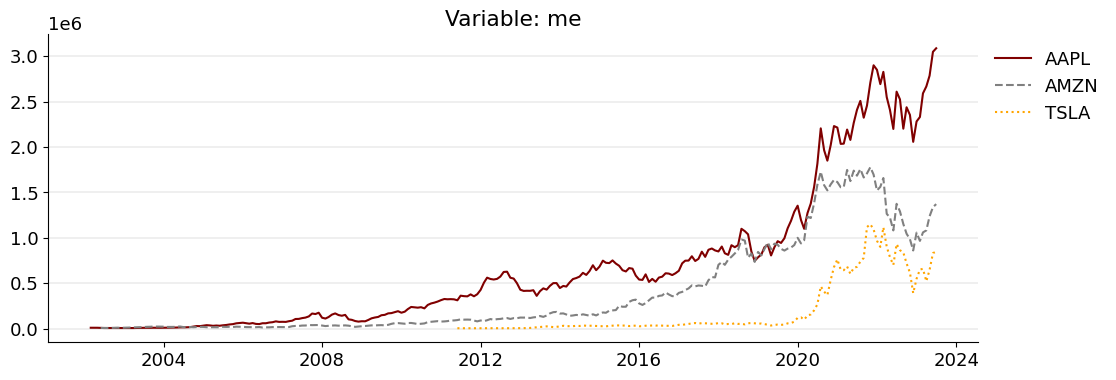

In [12]:
qpm.plot_variables(df_full, variable_list = ['me'],  id_type = 'ticker', id_list = ['AAPL', 'AMZN', 'TSLA'],
                     start_date = '1999-01-01', end_date = '2023-08-31')

#### Construct Signal

In [13]:
if _STRATEGY_NAME == 'Size':

	df_full['signal'] = 1 / df_full['me']
	
elif _STRATEGY_NAME == 'Value':

	df_full['signal'] = df_full['be'] / df_full['me']

elif _STRATEGY_NAME == 'ESG':

	df_full['signal'] = -df_full['carbon_intensity']	

elif _STRATEGY_NAME == 'Quality':

	# Signal 1 : Rank(Low Beta)
	df_full['beta_inv'] = -df_full['beta']
	df_full['signal_1'] = qpm.rank(df_full, var_name = 'beta_inv')

	# Signal 2 : Rank(profitA)
	df_full['signal_2'] = qpm.rank(df_full, var_name = 'profitA')

	# Final Signal
	df_full['signal'] = (df_full['signal_1'] + df_full['signal_2']) / 2

elif _STRATEGY_NAME == 'AssetGrowth':

	df_full['signal'] = -df_full['at'] / qpm.create_lag(df_full, var_name = 'at', lag = 12)

elif _STRATEGY_NAME == 'Momentum':

	# Sort data
	df_full.sort_values(['permno', 'ldate'], ascending = [True, True], inplace = True)      

	# Check that we have 12 observations for a stock
	df_full['ldate12'] = df_full[['ldate','permno']].groupby('permno')['ldate'].shift(12)
	df_full['signal'] = (df_full['ldate'] == df_full['ldate12'] + pd.DateOffset(months = 12)).map(lambda x : 0 if x else np.nan)

	# In month t, add the returns from t-1, t-2, ..., t-12. Hence, we skip one month
	for i in range(1, 11 + 1):
		# Create a variable for each lag of the returns
		df_full['daret%d' %(i)] = df_full[['daret', 'permno']].groupby('permno')['daret'].shift(i)
		
		# Sum the returns over the last year
		df_full['signal'] += df_full['daret%d' %(i)].notnull() * np.log(1 + df_full['daret%d' %(i)]).fillna(0.0)
		
		# Drop the variable that we created in the previous step
		df_full.drop(columns = ['daret%d' %(i)], inplace = True)

elif _STRATEGY_NAME == 'STreversal':

	df_full['signal'] = -df_full['daret']				
        
else:
	
	raise Exception('Please provide a valid _STRATEGY_NAME..')  
    
df_sum = df_full.sort_values(['ldate','ticker'])	
print(df_sum[['ldate','ticker','me','signal']].loc[df_sum['ticker'].isin(['AAPL', 'AMZN', 'TSLA'])].tail(3))    

             ldate ticker            me    signal
121071  2023-07-01   AAPL  3.089904e+06 -0.012785
691699  2023-07-01   AMZN  1.371604e+06 -0.025468
1074188 2023-07-01   TSLA  8.488228e+05 -0.021622


#### Sample Selection

In [14]:
# Lag signal by one period so that the signal value is known at the time of portfolio creation
df_full['signal'] = qpm.create_lag(df_full, var_name = 'signal', lag = 1)

df = qpm.select_sample(df_full, sample_start = _SAMPLE_START, sample_end = _SAMPLE_END, remove_micro_caps = _REMOVE_MICRO_CAPS)

> Selecting Sample for Given Criteria...


### Step 2. Portfolio Construction

In [15]:
df, df_rets = qpm.create_portfolios(df, sort_frequency = _SORT_FREQUENCY, num_port = _NUM_PORT)
print(df_rets.tail())

> Sorting stocks into 5 portfolios at frequency: Monthly...
> Computing returns using various weights...
         ldate  retP_rank_longonly  retP_rank_longshort  retP_vw_P1  \
259 2023-03-01           -0.072666            -0.038146    0.048933   
260 2023-04-01           -0.024051            -0.011294    0.014523   
261 2023-05-01            0.007320             0.035608   -0.013576   
262 2023-06-01            0.063142             0.009104    0.076832   
263 2023-07-01            0.046519            -0.023589    0.041383   

     retP_vw_P2  retP_vw_P3  retP_vw_P4  retP_vw_P5   retF_vw  
259    0.045083    0.003146    0.020093    0.018853 -0.030080  
260    0.003719    0.001530    0.005741   -0.008399 -0.022922  
261   -0.005179    0.028702   -0.020756    0.080992  0.094567  
262    0.071224    0.062130    0.065504    0.073984 -0.002848  
263    0.053633    0.033059    0.024932    0.044495  0.003112  


### Step 3. Portfolio Analytics

> Merging strategy returns with Fama and French factor returns...


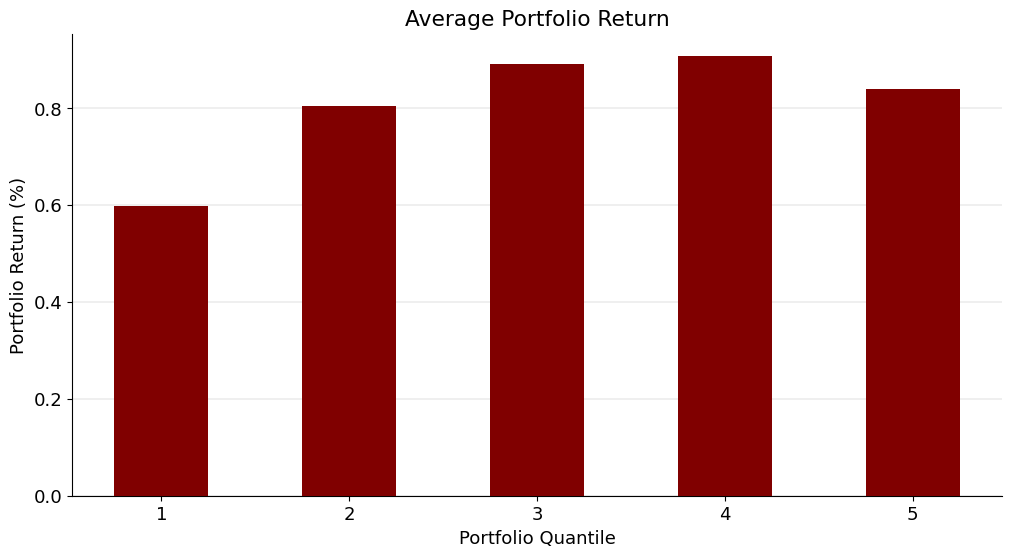

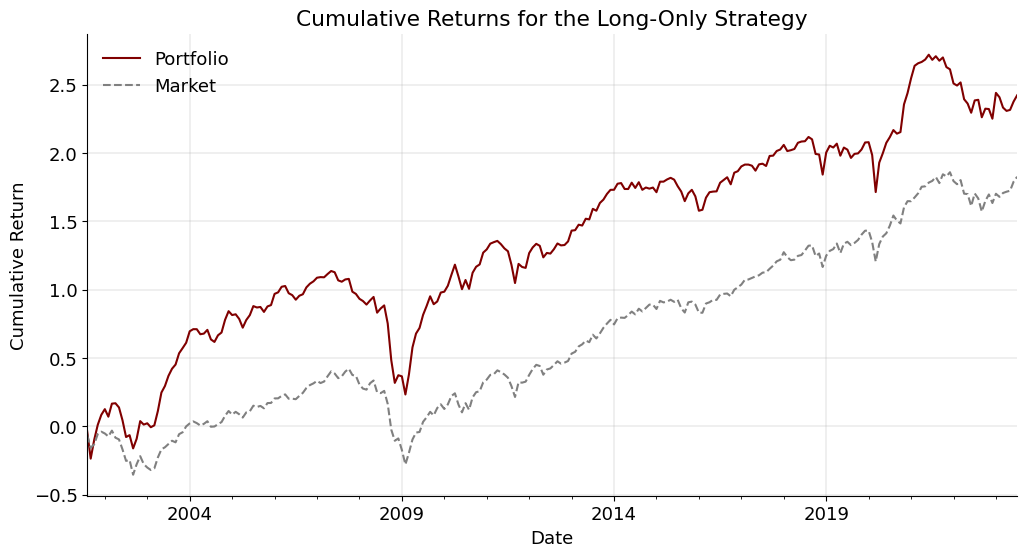

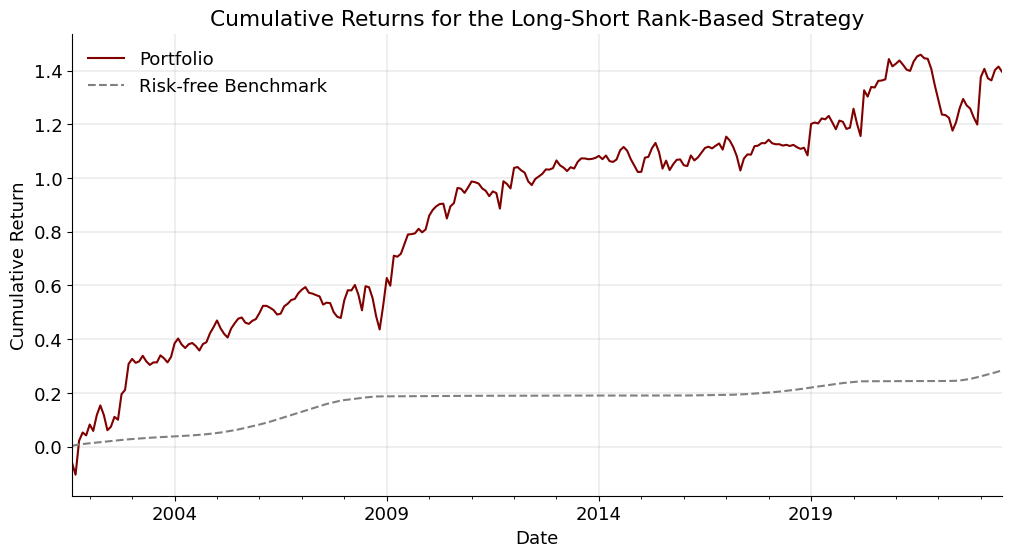

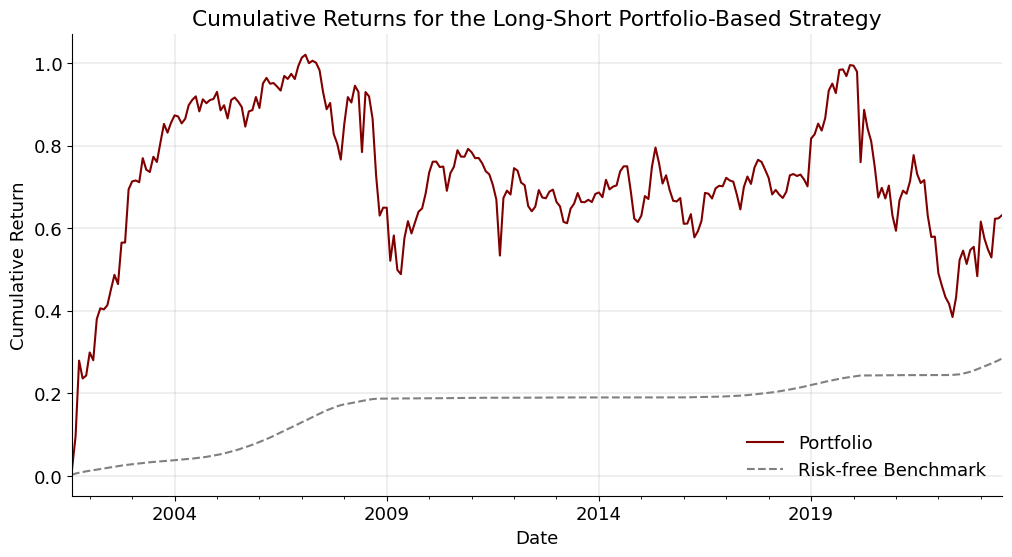

In [16]:
qpm.analyze_strategy(df_rets, analysis_type = 'Performance')

In [17]:
qpm.analyze_strategy(df_rets, analysis_type = 'Summary')

> Merging strategy returns with Fama and French factor returns...
                     count      mean       std       min       25%       50%  \
retP_rank_longonly   264.0  0.011462  0.067034 -0.237268 -0.022667  0.011097   
retP_rank_longshort  264.0  0.004851  0.036314 -0.065750 -0.014921  0.001019   
retF_vw              264.0  0.002408  0.046925 -0.197984 -0.020966 -0.000213   
mktrf                264.0  0.006891  0.045259 -0.172300 -0.018425  0.012300   
smb                  264.0  0.001802  0.026613 -0.082800 -0.015075  0.001750   
hml                  264.0 -0.000172  0.031180 -0.138700 -0.016775 -0.001350   

                          75%       max  
retP_rank_longonly   0.045123  0.240202  
retP_rank_longshort  0.017941  0.189349  
retF_vw              0.024615  0.199362  
mktrf                0.032625  0.136500  
smb                  0.018900  0.071300  
hml                  0.015325  0.127500  


In [18]:
qpm.analyze_strategy(df_rets, analysis_type = 'Factor Regression')

> Merging strategy returns with Fama and French factor returns...

---------------------------------------------------------------
> Running Factor Regressions: Table 1  - 3 Fama-French Factors
---------------------------------------------------------------

                  (1)       (2)       (3)       (4)       (5)       (6)   
--------------------------------------------------------------------------
const          0.0001    0.0014    0.0026    -0.0000   0.0009    0.0024   
               (0.0028)  (0.0020)  (0.0021)  (0.0027)  (0.0013)  (0.0020) 
mktrf          0.3402*** 1.3072*** 0.3253*** 0.2771*** 1.1187*** 0.2862***
               (0.0605)  (0.0434)  (0.0453)  (0.0636)  (0.0308)  (0.0472) 
hml                                          0.0471    -0.0270   -0.1657**
                                             (0.0902)  (0.0437)  (0.0670) 
smb                                          0.2970*** 0.9557*** 0.2629***
                                             (0.1116)  (0.0540)  (

In [19]:
if _REMOVE_MICRO_CAPS:
    save_dir = '%s/StrategyReturns_%s_%s_noMicroCaps.csv' %(_STRATEGY_DIR, _STRATEGY_NAME, _SORT_FREQUENCY)
else:
    save_dir = '%s/StrategyReturns_%s_%s_withMicroCaps.csv' %(_STRATEGY_DIR, _STRATEGY_NAME, _SORT_FREQUENCY)

df_rets.to_csv(save_dir)
print('Saved Strategy Returns to %s' %(save_dir))

Saved Strategy Returns to /Users/jiahongcai/Desktop/Quantitative Strategies/Strategies/Return/StrategyReturns_STreversal_Monthly_withMicroCaps.csv
